 # Spatial Autoregressive Models (SAR)                                                                   

Models for irregular lattice data (polygon) to predict number of recent landslides in 651 catchments located in the northern Colombian Andes.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import libpysal
from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sbn
import researchpy as rp
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
import geopandas as gpd
import seaborn as sns
from sklearn.decomposition import PCA


In [363]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pca

                                              0.0/51.3 kB ? eta -:--:--
                                              0.0/51.3 kB ? eta -:--:--
     -------                                  10.2/51.3 kB ? eta -:--:--
     -------                                  10.2/51.3 kB ? eta -:--:--
     ----------------------                 30.7/51.3 kB 262.6 kB/s eta 0:00:01
     -------------------------------------- 51.3/51.3 kB 293.2 kB/s eta 0:00:00


## Data

In [2]:
gdf = gpd.read_file("G:/My Drive/INVESTIGACION/POSDOC/Data/Vector/df_catchments_kmeans.gpkg")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   533 non-null    int64   
 1   ID_CUENCA            533 non-null    float64 
 2   Nombre               533 non-null    object  
 3   kmeans               533 non-null    object  
 4   NOMZH                533 non-null    object  
 5   Área                 533 non-null    float64 
 6   elev_mean            533 non-null    float64 
 7   elev_median          533 non-null    float64 
 8   rel_mean             533 non-null    float64 
 9   rel_median           533 non-null    float64 
 10  rainfallAnnual_mean  533 non-null    float64 
 11  Densidad             533 non-null    float64 
 12  hypso_inte           533 non-null    float64 
 13  slope_mean           533 non-null    float64 
 14  RainfallDaysmean     533 non-null    float64 
 15  RainfallDaysmed

In [3]:
gdf["landslide_dens"]=gdf["lands_rec"]/gdf["Área"]

In [4]:
gdf.head(1)

,id,ID_CUENCA,Nombre,kmeans,NOMZH,Área,elev_mean,elev_median,rel_mean,rel_median,...,hypso_inte,slope_mean,RainfallDaysmean,RainfallDaysmedian,landcovermedian,geomedian,lands_rec,knn5,geometry,landslide_dens
0,1,1.0,Quebrada Sabalito,A,Cauca,33.492364,58.212878,57.070824,25.697303,26.0,...,0.334,4.334927,2611.998779,2581.0,grass,sediment,0.0,A,"POLYGON ((505464.576 881616.272, 505673.255 88...",0.0


## EDA

In [169]:
rp.summary_cont(gdf.groupby(["NOMZH", "kmeans4"])["hypso_inte"])

N    Mean      SD      SE  95% Conf.  Interval
NOMZH     kmeans4                                                  
Atrato    A          5  0.4876  0.1317  0.0589     0.3240    0.6512
          B         27  0.2204  0.0970  0.0187     0.1820    0.2587
          C         60  0.4204  0.0615  0.0079     0.4045    0.4362
          D         39  0.3784  0.0911  0.0146     0.3488    0.4079
Cauca     A         22  0.5658  0.0745  0.0159     0.5328    0.5989
          B         18  0.2904  0.0897  0.0211     0.2458    0.3350
          C         73  0.4659  0.0765  0.0090     0.4481    0.4837
          D         18  0.3684  0.0582  0.0137     0.3394    0.3974
Magdalena A         59  0.5012  0.1290  0.0168     0.4676    0.5348
          B         58  0.2772  0.0834  0.0109     0.2553    0.2992
          C         36  0.4612  0.0538  0.0090     0.4430    0.4795
          D        118  0.4524  0.0844  0.0078     0.4370    0.4678

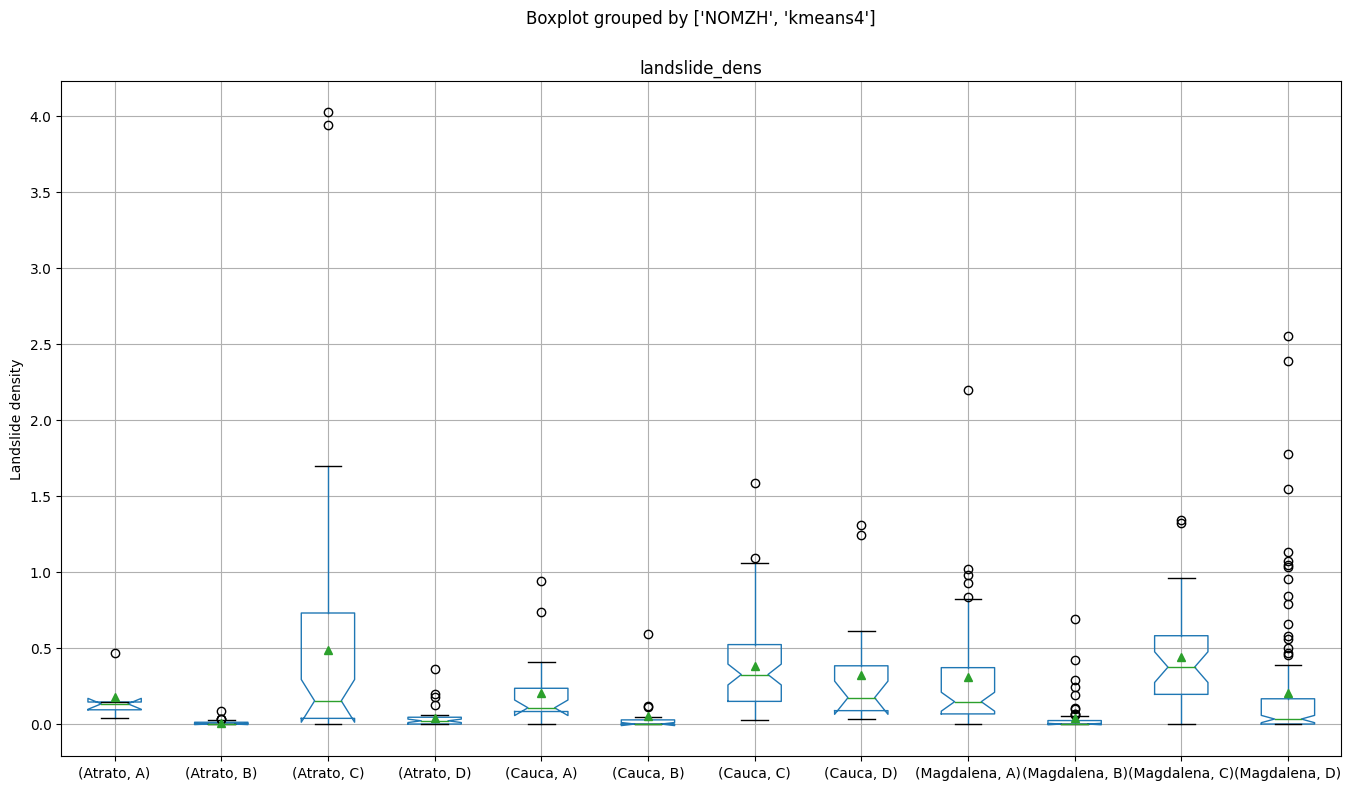

In [170]:
boxplot = gdf.boxplot(["landslide_dens"], by = ["NOMZH", "kmeans4"],figsize = (16, 9),showmeans = True,notch = True)
boxplot.set_xlabel("")
boxplot.set_ylabel("Landslide density");

In [404]:
var=['Área','hypso_inte','Densidad','rainfallAnnual_mean','elev_mean','slope_mean','rel_mean','RainfallDaysmean']

In [405]:
from sklearn.preprocessing import StandardScaler
st = StandardScaler()

In [406]:
dfs = pd.DataFrame(st.fit_transform(gdf[var]), index=gdf[var].index, columns=gdf[var].columns)

In [407]:
dfs["landslide_dens"]=gdf["landslide_dens"]
dfs["knn5"]=gdf["knn5"]
dfs["basin"]=gdf["NOMZH"]
dfs["landcovermedian"]=gdf['landcovermedian']
dfs['geomedian']=gdf['geomedian']
dfs = dfs.replace([np.nan, -np.inf], 0)

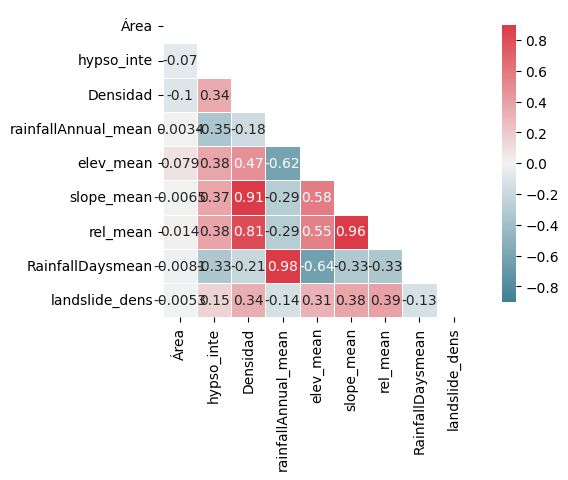

In [115]:
corr=DataFrame(gdf[var].corr())
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8,4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.9,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.9,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": 0.9}  # Extra kwargs for the legend; in this case, shrink by 50%
);
f.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/correlation_matrix.png')

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_df = pd.DataFrame()
vif_df["VIF Factor"] = [vif(gdf[var].values, i) for i in range(gdf[var].shape[1])]
vif_df["features"] = gdf[var].columns
vif_df.round(1)

,VIF Factor,features
0,2.1,Área
1,12.8,hypso_inte
2,38.6,Densidad
3,214.4,rainfallAnnual_mean
4,9.5,elev_mean
5,237.2,slope_mean
6,62.2,rel_mean
7,134.6,RainfallDaysmean
8,1.7,landslide_dens


In [376]:
pca = PCA(n_components=8).fit(dfs)

In [385]:
print(pca.explained_variance_ratio_)

[0.50096669 0.20981271 0.12887179 0.09036135 0.04461688 0.02140158
 0.00223653 0.00173247]


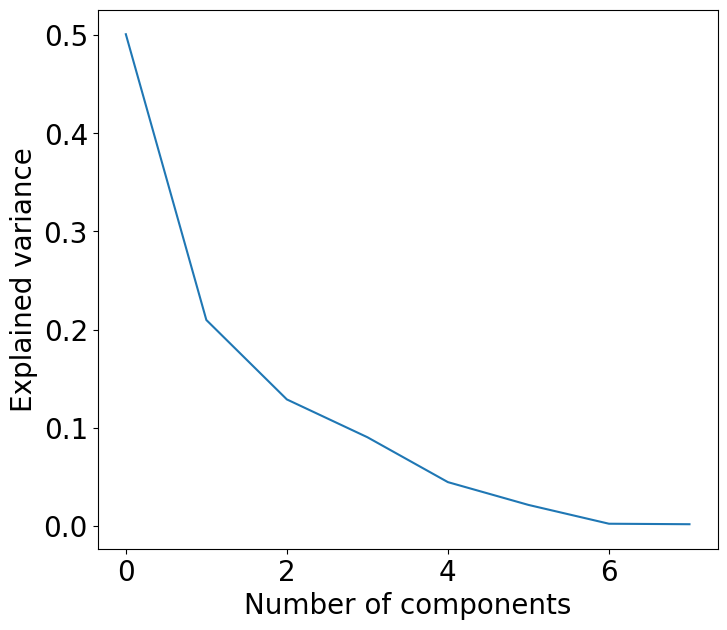

In [384]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

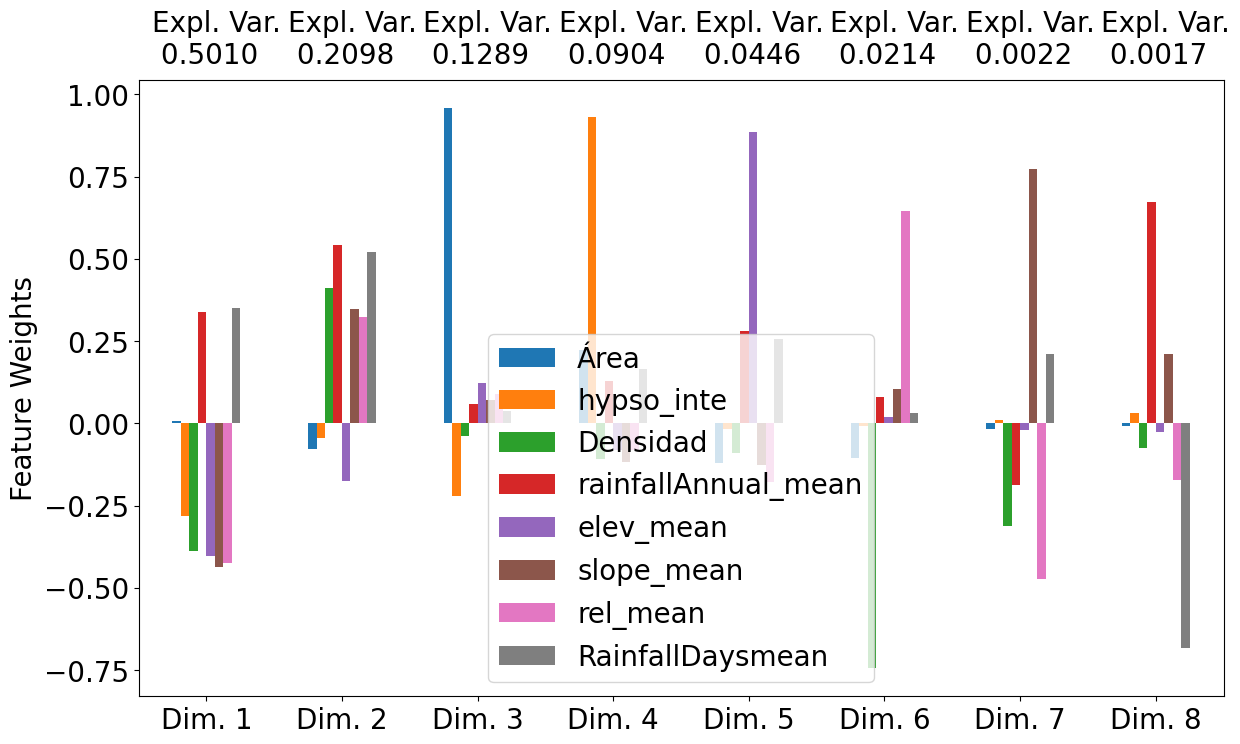

In [378]:
def pca_results(X_scaled, pca):

    dimensions = ['Dim. {}'.format(i) for i in range(1,len(pca.components_)+1)]

    components = pd.DataFrame(np.round(pca.components_, 4), columns = X_scaled.keys())
    components.index = dimensions

    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (14,8))

    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Expl. Var.\n %.4f"%(ev))

    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(dfs, pca)

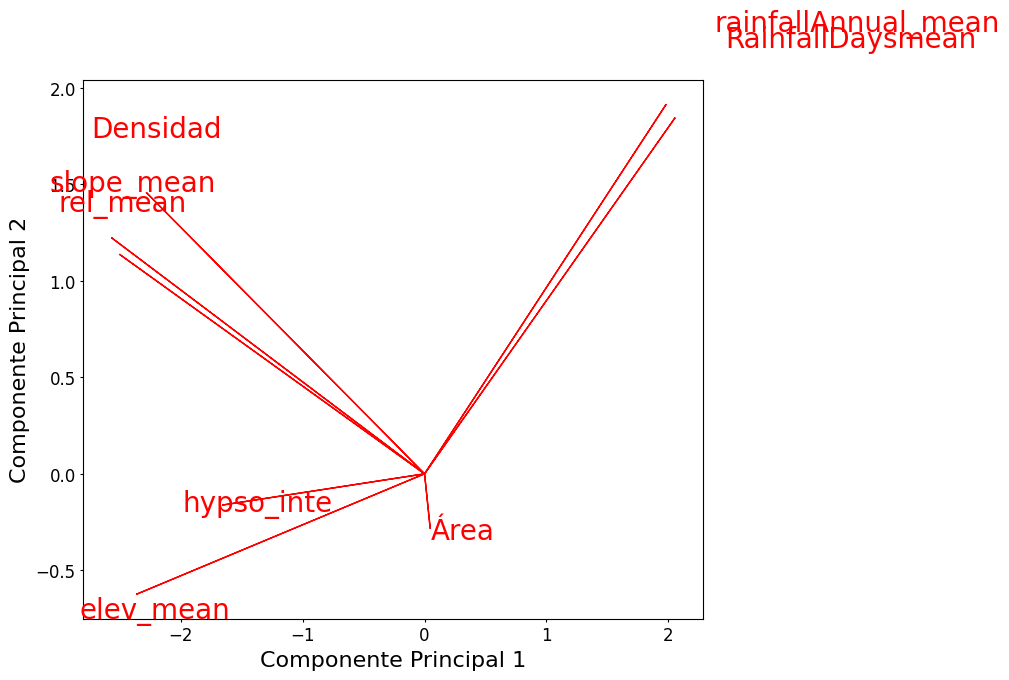

In [383]:
xvector = pca.components_[0]
yvector = pca.components_[1]

xs = pca.transform(dfs)[:,0]
ys = pca.transform(dfs)[:,1]

## Para visualizar las proyecciones de cada variable en los componentes se utiliza la siguiente función
for i in range(len(xvector)):
# arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(dfs.columns.values)[i], color='r')

plt.tick_params('y', colors='k', labelsize=12, length=2)
plt.tick_params('x', colors='k', labelsize= 12, length=2)
plt.xlabel("Componente Principal 1", fontsize=16)
plt.ylabel("Componente Principal 2", fontsize=16)
plt.show()

In [408]:
dfs.head(1)

,Área,hypso_inte,Densidad,rainfallAnnual_mean,elev_mean,slope_mean,rel_mean,RainfallDaysmean,landslide_dens,knn5,basin,landcovermedian,geomedian
0,-0.581936,-0.688209,-2.006346,0.226296,-1.644703,-2.148244,-1.75022,0.398309,0.0,A,Magdalena,grass,sediment


## Spatial analysis

### For recent landslide density

In [409]:
landslides = dfs["landslide_dens"]
y = np.array(landslides)
y.shape = (len(landslides), 1)

In [441]:
var1=[] #para tener los nombres de las variables que se utilizan, que entra en el argumento name_x
X1 = []
#X1.append(dfs["Área"]);var1.append("Área")
X1.append(dfs["hypso_inte"]);var1.append("hypso_inte")
X1.append(dfs["Densidad"]);var1.append("Densidad")
#X1.append(dfs["rainfallAnnual_mean"]);var1.append("rainfallAnnual_mean")
#X1.append(dfs["elev_mean"]);var1.append("elev_mean")
#X1.append(dfs["slope_mean"]);var1.append("slope_mean")
X1.append(dfs["rel_mean"]);var1.append("rel_mean")
#X1.append(dfs["RainfallDaysmean"]);var1.append("RainfallDaysmean")
lc_encoded = pd.get_dummies(dfs["landcovermedian"])
#X1.append(lc_encoded["grass"]);var1.append("grass")
X1.append(lc_encoded["forest"]);var1.append("forest")
geo_encoded = pd.get_dummies(dfs["geomedian"])
#X1.append(geo_encoded["volcanic"]);var1.append("volcanic")
X1.append(geo_encoded["granitic"]);var1.append("granitic")
X1.append(geo_encoded["sediment"]);var1.append("sediment")
X1= np.array(X1).T

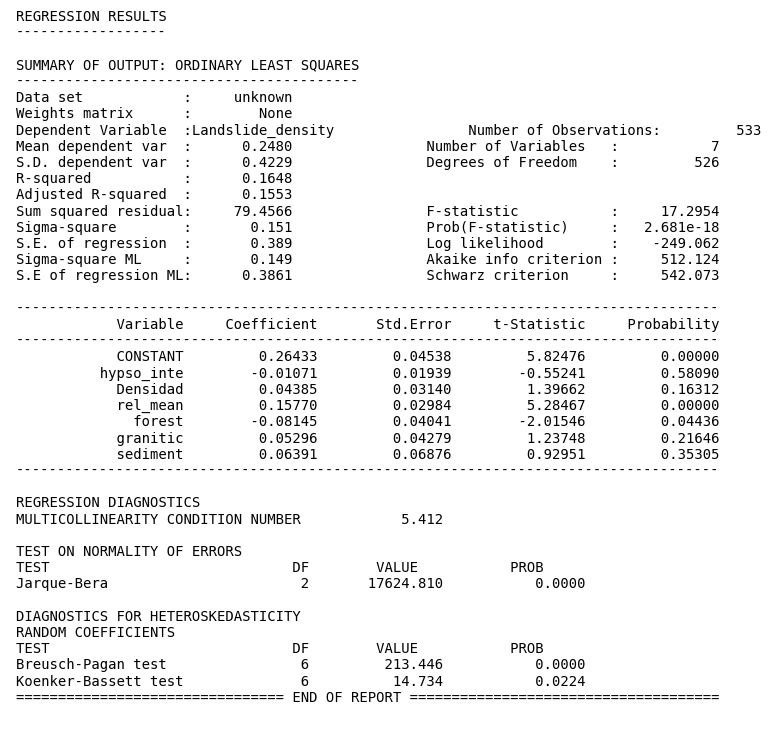

In [442]:
m1 = spreg.OLS(y,X1,name_y='Landslide_density',name_x=var1)
#print(m1.summary)
plt.rc("figure", figsize=(8, 7))
plt.text(0.01, 0.05, str(m1.summary), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm1_lads_rec_spreg.png', dpi=300, bbox_inches='tight')

In [443]:
m1.betas

array([[ 0.26433455],
       [-0.01071143],
       [ 0.04385327],
       [ 0.15770479],
       [-0.08145383],
       [ 0.05295502],
       [ 0.06391449]])

Se eliminan las variables que no son significativas

In [413]:
var2=[] #para tener los nombres de las variables que se utilizan, que entra en el argumento name_x
X2 = []
#X2.append(dfs["Área"]);var2.append("Área")
#X2.append(dfs["hypso_inte"]);var2.append("hypso_inte")
#X2.append(dfs["Densidad"]);var2.append("Densidad")
#X2.append(dfs["rainfallAnnual_mean"]);var2.append("rainfallAnnual_mean")
X2.append(dfs["elev_mean"]);var2.append("elev_mean")
X2.append(dfs["slope_mean"]);var2.append("slope_mean")
#X2.append(dfs["rel_mean"]);var2.append("rel_mean")
X2.append(dfs["RainfallDaysmean"]);var2.append("RainfallDaysmean")
#lc_encoded = pd.get_dummies(dfs["landcovermedian"])
#X2.append(lc_encoded["grass"]);var2.append("grass")
#X2.append(lc_encoded["forest"]);var2.append("forest")
#geo_encoded = pd.get_dummies(dfs["geomedian"])
#X2.append(geo_encoded["volcanic"]);var2.append("volcanic")
#X2.append(geo_encoded["granitic"]);var2.append("granitic")
#X2.append(geo_encoded["sediment"]);var2.append("sediment")
X2= np.array(X2).T

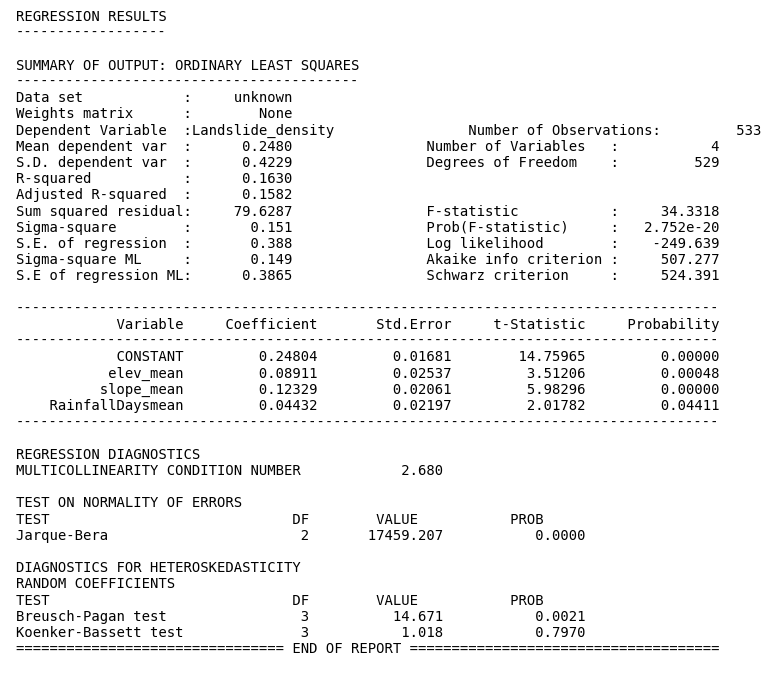

In [414]:
m2 = spreg.OLS(y,X2,name_y='Landslide_density',name_x=var2)
#print(m2.summary)
plt.rc("figure", figsize=(8, 7))
plt.text(0.01, 0.05, str(m2.summary), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/Hi_OLS.png', dpi=300, bbox_inches='tight')

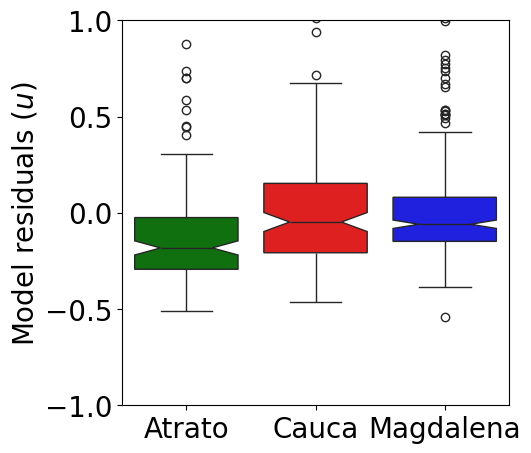

In [389]:
gdf['residual'] = m2.u
medians = gdf.groupby("NOMZH").residual.median().to_frame('basin_residual')
data=gdf.merge(medians, how='left',left_on='NOMZH',right_index=True)
f,ax = plt.subplots(figsize=(5,5))
my_pal = {"Magdalena": "b", "Atrato": "g", "Cauca":"r"}
sns.boxplot(x='NOMZH',y='residual',ax=ax,data=data,palette=my_pal,notch=True,order=["Atrato","Cauca","Magdalena"])
ax.set_ylim(-1,1)
ax.set_ylabel("Model residuals ($u$)")
ax.set_xlabel("")
plt.locator_params(axis='y', nbins=4) 
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras2/NOMZH_res.png',dpi=500,bbox_inches='tight')

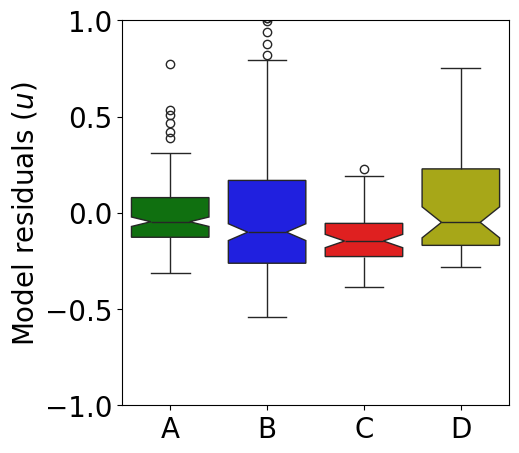

In [445]:
gdf['residual'] = m2.u
medians = gdf.groupby("knn5").residual.median().to_frame('basin_residual')
data=gdf.merge(medians, how='left',left_on='knn5',right_index=True)
f,ax = plt.subplots(figsize=(5,5))
my_pal = {"A": "g", "B": "b", "C":"r","D":"y"}
sns.boxplot(x='knn5',y='residual',ax=ax,data=data,palette=my_pal,notch=True,order=["A","B","C","D"])
ax.set_ylim(-1,1)
ax.set_ylabel("Model residuals ($u$)")
ax.set_xlabel("")
plt.locator_params(axis='y', nbins=4) 
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras2/knn5_res.png',dpi=500,bbox_inches='tight')

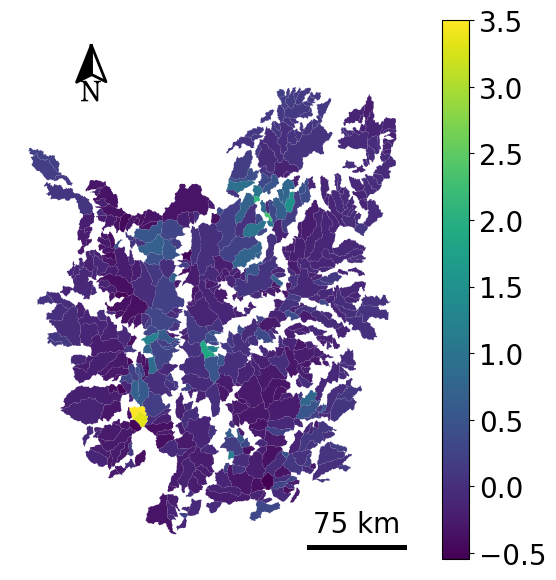

In [465]:
fig,ax=plt.subplots(figsize=(7,7))
gdf.plot(column="residual",ax=ax,legend=True)
add_north_arrow(ax, scale=.75, xlim_pos=.2, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)
ax.set_axis_off()
scalebar = ScaleBar(1,"m",location="lower right",scale_loc="top",length_fraction=0.25)
ax.add_artist(scalebar);
fig.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras2/m2u.png', dpi=500, bbox_inches='tight')

In [395]:
knn5 = weights.KNN.from_dataframe(gdf, k=5)

In [6]:
gdf.head(1)

,id,ID_CUENCA,Nombre,kmeans,NOMZH,Área,elev_mean,elev_median,rel_mean,rel_median,...,hypso_inte,slope_mean,RainfallDaysmean,RainfallDaysmedian,landcovermedian,geomedian,lands_rec,knn5,geometry,landslide_dens
0,1,1.0,Quebrada Sabalito,A,Cauca,33.492364,58.212878,57.070824,25.697303,26.0,...,0.334,4.334927,2611.998779,2581.0,grass,sediment,0.0,A,"POLYGON ((505464.576 881616.272, 505673.255 88...",0.0


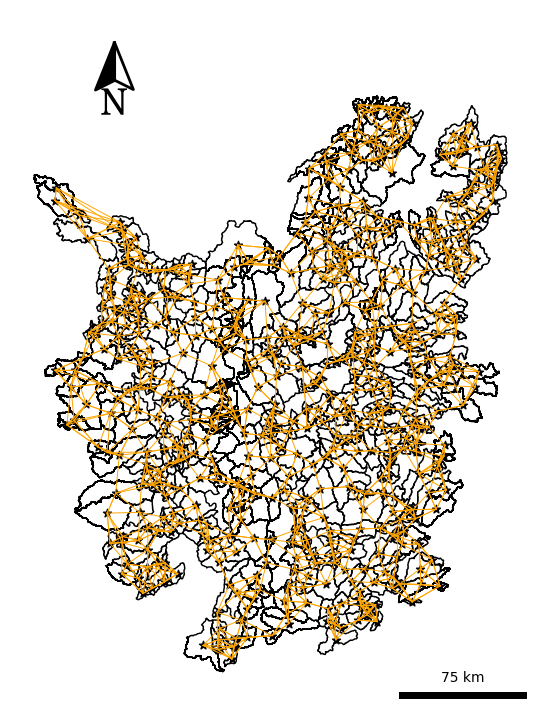

In [361]:
from matplotlib_scalebar.scalebar import ScaleBar
import geodatasets
from geo_northarrow import add_north_arrow


f, ax = plt.subplots(figsize=(9, 9))
gdf.plot(facecolor="none", edgecolor="black",ax=ax)
knn5.plot(gdf,edge_kws=dict(linewidth=0.7,color="orange"),node_kws=dict(marker="*"),ax=ax,)
ax.set_axis_off()
add_north_arrow(ax, scale=.75, xlim_pos=.2, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)
scalebar = ScaleBar(1,"m",location="lower right",scale_loc="top",length_fraction=0.25)
ax.add_artist(scalebar);
f.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras2/knn5.png', dpi=500, bbox_inches='tight')

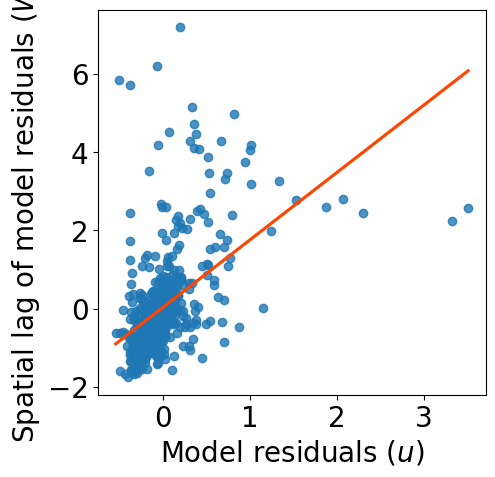

In [396]:
fig,ax=plt.subplots(figsize=(5,5))
lag_residual = weights.lag_spatial(knn5, m2.u)
ax = sbn.regplot(x=m2.u.flatten(),y=lag_residual.flatten(),line_kws=dict(color="orangered"),ci=None,)
ax.set_xlabel("Model residuals ($u$)")
ax.set_ylabel("Spatial lag of model residuals ($W_u$)")
plt.locator_params(axis='x', nbins=6) 
plt.locator_params(axis='y', nbins=6) 
fig.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras2/spatiallag_res.png', dpi=500, bbox_inches='tight');

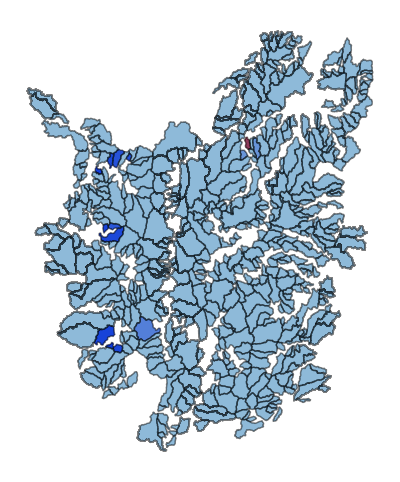

In [398]:
knn5.transform = "R"
outliers = esda.moran.Moran_Local(m2.u, knn5, permutations=9999)
error_clusters = outliers.q % 2 == 1
error_clusters &= outliers.p_sim <= 0.001
fig,ax=plt.subplots(figsize=(6,6))
gdf.assign(error_clusters=error_clusters,local_I=outliers.Is).query("error_clusters").sort_values("local_I").plot("local_I", ax=ax,cmap="bwr", marker=".")
gdf.plot(ax=ax,alpha=0.5,edgecolor='k')
ax.set_axis_off()
fig.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/m2u_moran.png', dpi=500, bbox_inches='tight');

#### Spatial hetereogenety

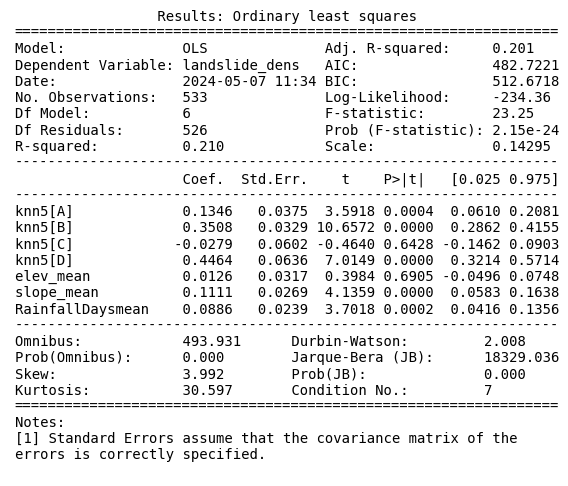

In [415]:
m4_cluster = smf.ols("landslide_dens~knn5+elev_mean+slope_mean+RainfallDaysmean-1",data=dfs).fit()
plt.rc("figure", figsize=(6, 5))
plt.text(0.01, 0.05, str(m4_cluster.summary2()), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm4_lads_rec_smf_cluster.png', dpi=300, bbox_inches='tight')

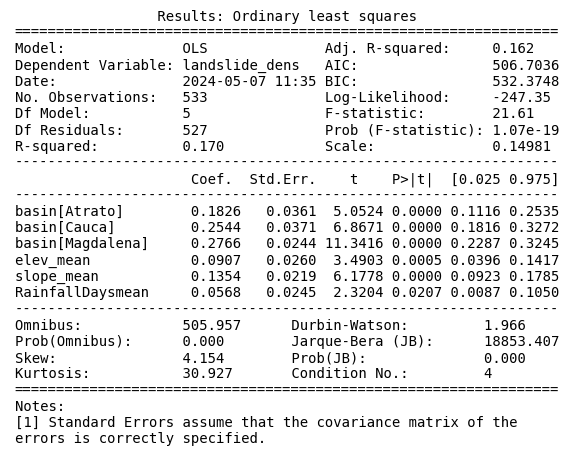

In [417]:
m4_cuencas = smf.ols("landslide_dens~basin+elev_mean+slope_mean+RainfallDaysmean-1",data=dfs).fit()
plt.rc("figure", figsize=(6, 5))
plt.text(0.01, 0.05, str(m4_cuencas.summary2()), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm4_lads_rec_smf_cuencas.png', dpi=300, bbox_inches='tight')

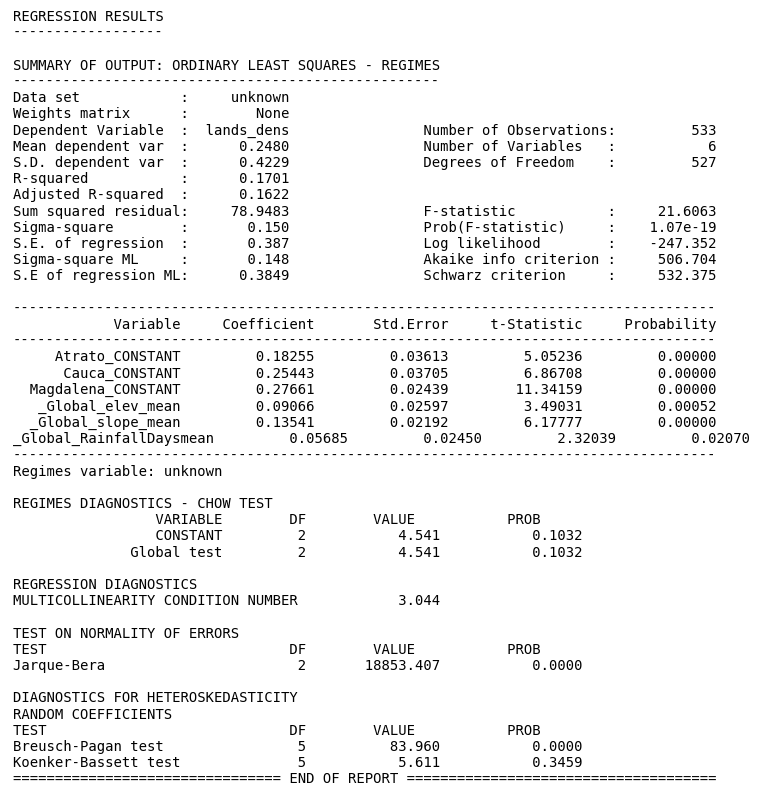

In [418]:
m5_cuencas = spreg.OLS_Regimes(y, X2,
                       gdf['NOMZH'].tolist(),
                       constant_regi='many', cols2regi=[False]*len(var2),
                       regime_err_sep=False,
                       name_y='lands_dens', name_x=var2)
#print(m5.summary)
plt.rc("figure", figsize=(6, 5))
plt.text(0.01, 0.05, str(m5_cuencas.summary), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm5_lads_spreg_cuencas.png', dpi=300, bbox_inches='tight')

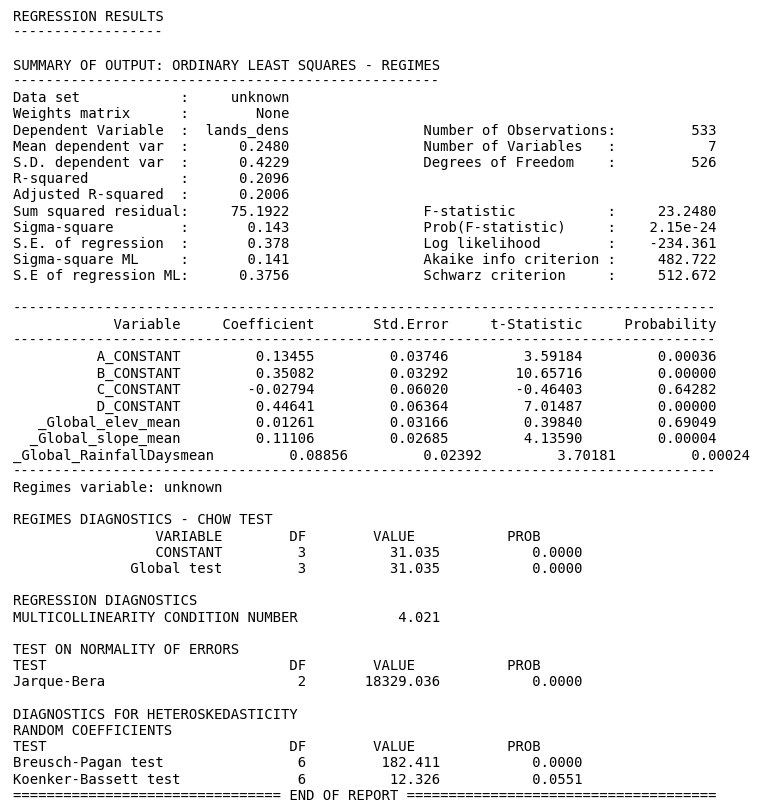

In [419]:
m5_cluster = spreg.OLS_Regimes(y, X2,
                       gdf['knn5'].tolist(),
                       constant_regi='many', cols2regi=[False]*len(var2),
                       regime_err_sep=False,
                       name_y='lands_dens', name_x=var2)
#print(m5.summary)
plt.rc("figure", figsize=(6, 5))
plt.text(0.01, 0.05, str(m5_cluster.summary), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm5_lads_spreg_cluster.png', dpi=300, bbox_inches='tight')

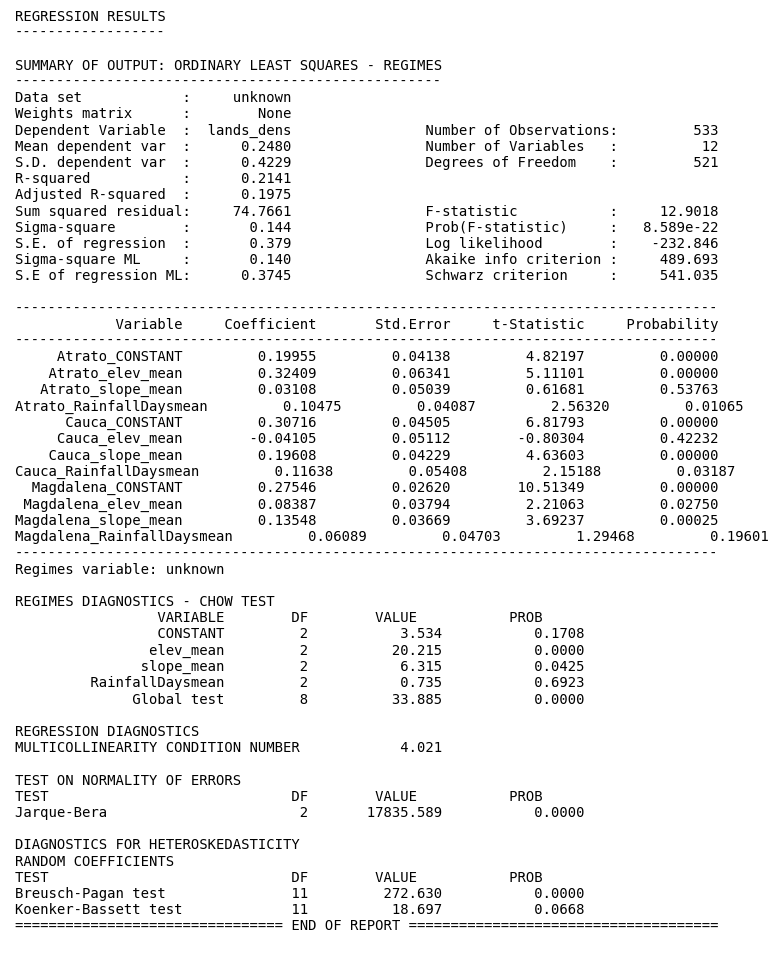

In [420]:
m6_cuenca = spreg.OLS_Regimes(y, X2,
                          gdf['NOMZH'].tolist(),
                          constant_regi='many',
                          regime_err_sep=False,
                          name_y='lands_dens', name_x=var2)
#print(m6.summary)
plt.rc("figure", figsize=(6, 5))
plt.text(0.01, 0.05, str(m6_cuenca.summary), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm6_lads_spreg_cuenca.png', dpi=300, bbox_inches='tight')

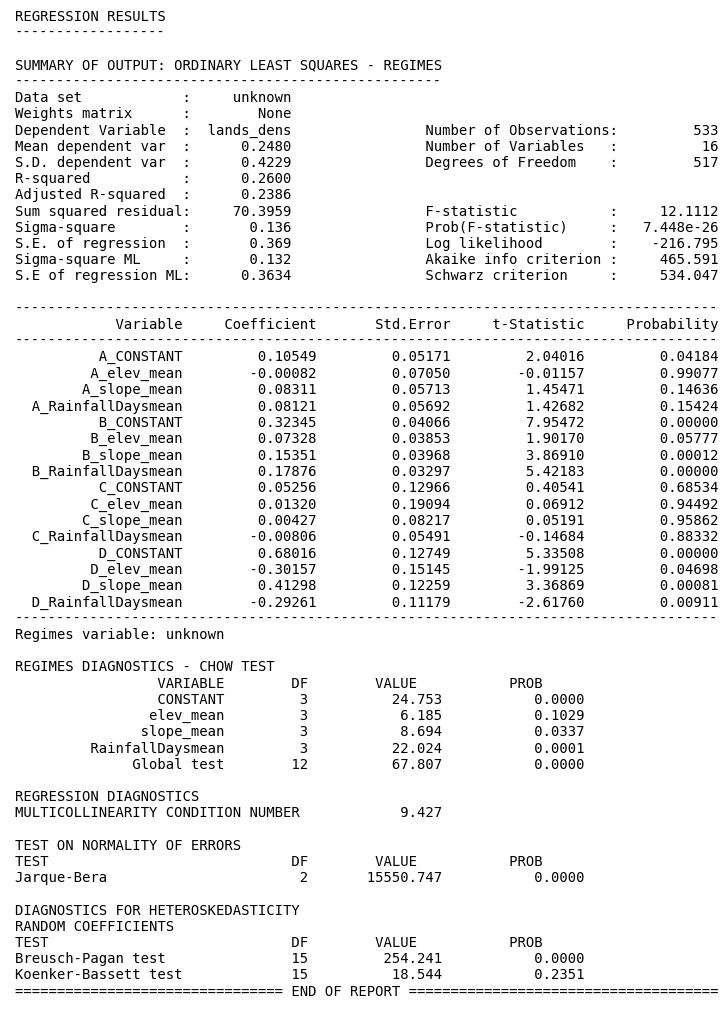

In [421]:
m6_cluster = spreg.OLS_Regimes(y, X2,
                          gdf['knn5'].tolist(),
                          constant_regi='many',
                          regime_err_sep=False,
                          name_y='lands_dens', name_x=var2)
#print(m6.summary)
plt.rc("figure", figsize=(6, 5))
plt.text(0.01, 0.05, str(m6_cluster.summary), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm6_lads_spreg_cluster.png', dpi=300, bbox_inches='tight')

#### Spatial dependency

In [422]:
wx = gdf[var2].apply(lambda y: weights.spatial_lag.lag_spatial(knn5, y)).rename(columns=lambda c: 'w_'+c)

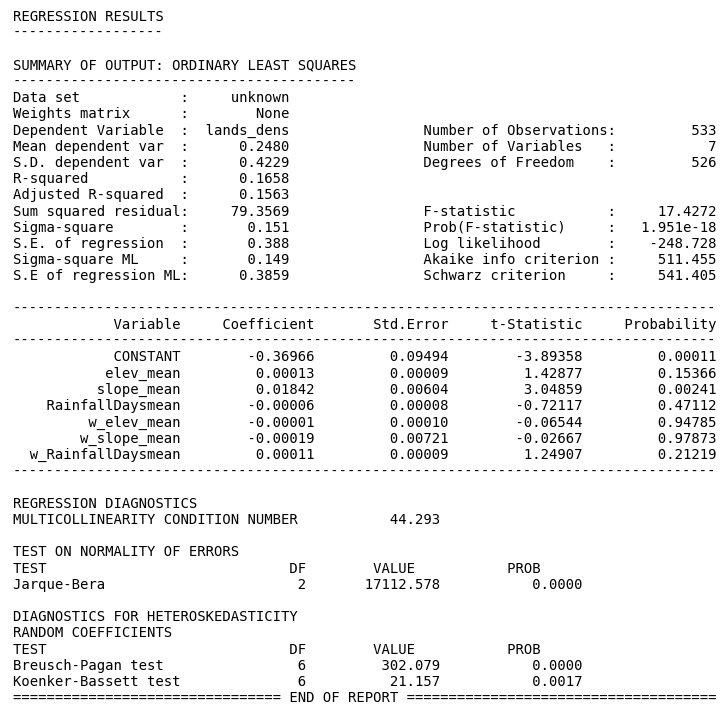

In [423]:
slx_exog = gdf[var2].join(wx)
m7 = spreg.OLS(y,slx_exog.values,name_y='lands_dens',name_x=slx_exog.columns.tolist())
#print(m7.summary)
plt.rc("figure", figsize=(6, 5))
plt.text(0.01, 0.05, str(m7.summary), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm7_lads_rec_spreg.png', dpi=300, bbox_inches='tight')

In [424]:
#Spatial lag
m8 = spreg.GM_Lag(y,X2,w=knn,name_y="Lands_dens",name_x=var2,)

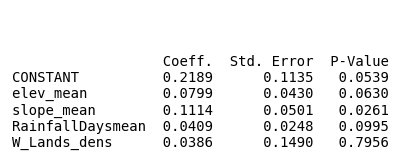

In [425]:
# Build full table of regression coefficients
m8_df=pd.DataFrame({"Coeff.": m8.betas.flatten(),"Std. Error": m8.std_err.flatten(),"P-Value": [i[1] for i in m8.z_stat],},
    index=m8.name_z).round(4)
plt.rc("figure", figsize=(4, 2))
plt.text(0.01, 0.05, str(m8_df), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm8_lads_rec_spreg.png', dpi=300, bbox_inches='tight')

In [426]:
# Fit spatial error model with `spreg`
m9 = spreg.GM_Error_Het(y,X2,w=knn,name_y="lands_dens",name_x=var2,)

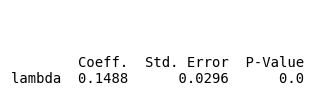

In [427]:
# Build full table of regression coefficients
m9_df=pd.DataFrame({"Coeff.": m9.betas.flatten(),"Std. Error": m9.std_err.flatten(),"P-Value": [i[1] for i in m9.z_stat],},
    index=m9.name_x).reindex(["lambda"]).round(4)
plt.rc("figure", figsize=(1, 1))
plt.text(0.01, 0.05, str(m9_df), {"fontsize": 10}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.gcf().tight_layout(pad=1.0)
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/regm9_lads_rec_spreg.png', dpi=300, bbox_inches='tight')

### The K-neighbor correlogram
Further, it might be the case that spatial dependence in our mispredictions only matters for sites that are extremely close to one another, and it decays quickly with distance. To investigate this, we can examine the correlation between each site’s residual and the average of the 
th nearest neighbors’ residuals, increasing 
 until the estimate stabilizes. This main idea is central to the geostatistical concept, the correlogram, which gives the correlation between sites of an attribute being studied as distance increases.

One quick way to check whether or not what we’ve seen is unique or significant is to compare it to what happens when we just assign neighbors randomly. If what we observe is substantially different from what emerges when neighbors are random, then the structure of the neighbors embeds a structure in the residuals. We won’t spend too much time on this theory specifically, but we can quickly and efficiently compute the correlation between our observed residuals and the spatial lag of an increasingnearest neighbor set:

In [88]:
correlations = []
nulls = []
for order in range(1, 51, 5):
    knn.reweight(k=order, inplace=True)
    knn.transform = "r"
    lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
    random_residual = m2.u[np.random.permutation(len(m2.u))]
    random_lag_residual = weights.spatial_lag.lag_spatial(knn, random_residual)
    correlations.append(np.corrcoef(m2.u.flatten(), lag_residual.flatten())[0, 1])
    nulls.append(np.corrcoef(m2.u.flatten(), random_lag_residual.flatten())[0, 1])

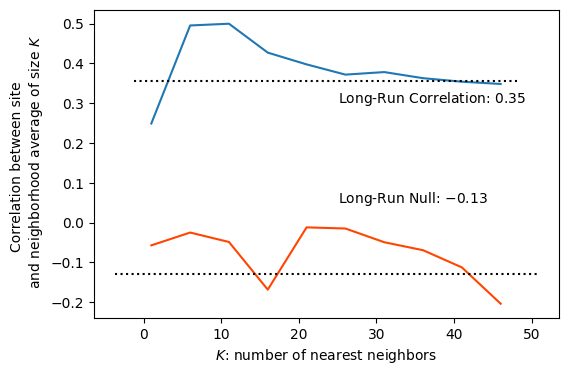

In [89]:
plt.rc("figure", figsize=(6,4))
plt.plot(range(1, 51, 5), correlations)
plt.plot(range(1, 51, 5), nulls, color="orangered")
plt.hlines(np.mean(correlations[-3:]),*plt.xlim(),linestyle=":",color="k")
plt.hlines(np.mean(nulls[-3:]), *plt.xlim(), linestyle=":", color="k")
plt.text(s="Long-Run Correlation: ${:.2f}$".format(np.mean(correlations[-3:])),x=25,y=0.3,)
plt.text(s="Long-Run Null: ${:.2f}$".format(np.mean(nulls[-3:])),x=25,y=0.05,)
plt.xlabel("$K$: number of nearest neighbors")
plt.ylabel("Correlation between site \n and neighborhood average of size $K$")
plt.savefig('G:/My Drive/INVESTIGACION/POSDOC/Figuras/Knn_correlogram_m2.png', dpi=300, bbox_inches='tight')